## QCNN Streamlined

Import Statements

In [24]:
#Import the required modules
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

Convolution Layers

     ┌──────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐
q_0: ┤ Rx(a[0]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rx(π/2) ├
     ├──────────┤└────┬────┘└────┬────┘└────┬────┘└────┬────┘
q_1: ┤ Rx(a[1]) ├─────■──────────■──────────┼──────────┼─────
     ├──────────┤┌─────────┐┌─────────┐     │          │     
q_2: ┤ Rx(a[2]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├─────■──────────■─────
     ├──────────┤└────┬────┘└────┬────┘                      
q_3: ┤ Rx(a[3]) ├─────■──────────■───────────────────────────
     └──────────┘                                            


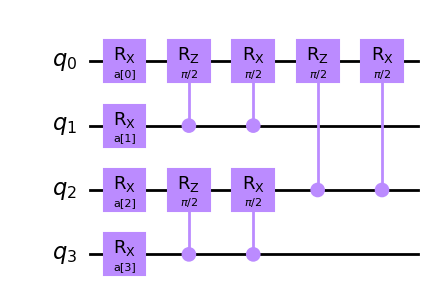

In [25]:
def conv_circuit(params):
    target = QuantumCircuit(4)
    #Apply the Rx gate with given parameteres
    for i in range(len(params)):
        target.rx(params[i],i)
    #Assuming that the gates without the angle are rotated by pi/2
    target.crz(np.pi / 2, 1, 0)
    target.crx(np.pi / 2, 1, 0)
    target.crz(np.pi/2, 3, 2) #Apply controlled Rz to 3rd and 4
    target.crx(np.pi/2 , 3, 2)
    target.crz(np.pi/2 , 2, 0)
    target.crx(np.pi/2, 2, 0 )
    print(target)
    return target

params = ParameterVector("a",length = 4)
circuit = conv_circuit(params)
circuit.draw("mpl")

    
    

Convolutional Layer

     ┌──────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐
q_0: ┤ Rx(θ[0]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rx(π/2) ├
     ├──────────┤└────┬────┘└────┬────┘└────┬────┘└────┬────┘
q_1: ┤ Rx(θ[1]) ├─────■──────────■──────────┼──────────┼─────
     ├──────────┤┌─────────┐┌─────────┐     │          │     
q_2: ┤ Rx(θ[2]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├─────■──────────■─────
     └──────────┘└────┬────┘└────┬────┘                      
q_3: ─────────────────■──────────■───────────────────────────
                                                             
     ┌──────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐
q_0: ┤ Rx(θ[3]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rx(π/2) ├
     ├──────────┤└────┬────┘└────┬────┘└────┬────┘└────┬────┘
q_1: ┤ Rx(θ[4]) ├─────■──────────■──────────┼──────────┼─────
     ├──────────┤┌─────────┐┌─────────┐     │          │     
q_2: ┤ Rx(θ[5]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├─────■──────────■─────
     └──────────┘└────┬────┘└────┬────┘                      
q_3: ───

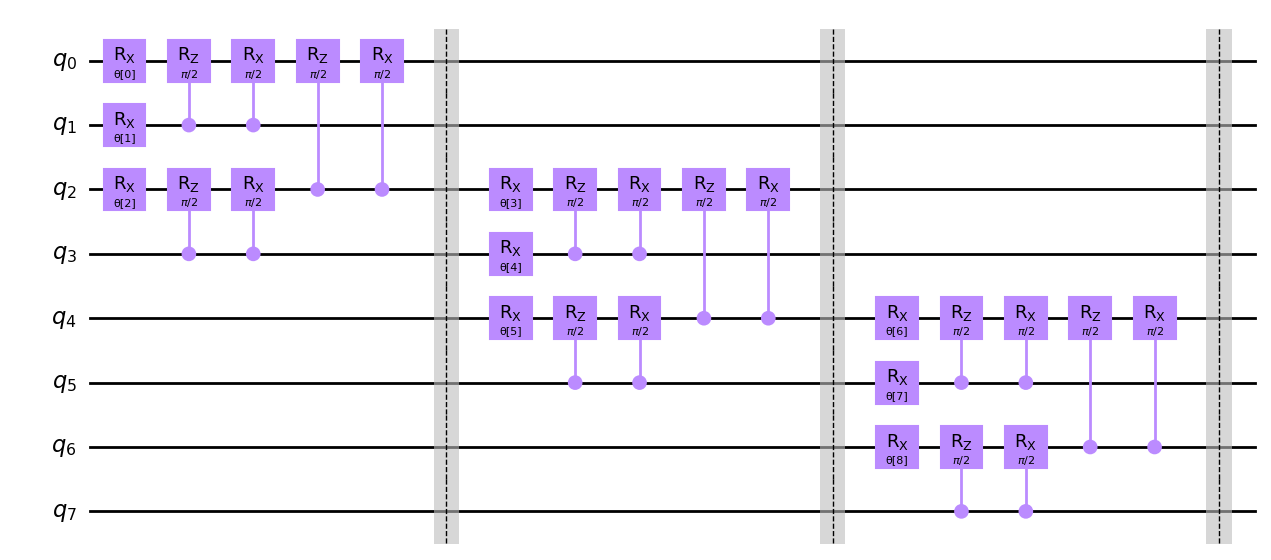

In [26]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)

    for i in range(0, num_qubits - 3, 2):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), qubits[i : i + 4])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc
circuit = conv_layer(8, "θ")
circuit.decompose().draw("mpl")

### Alternative Convolutional Definition

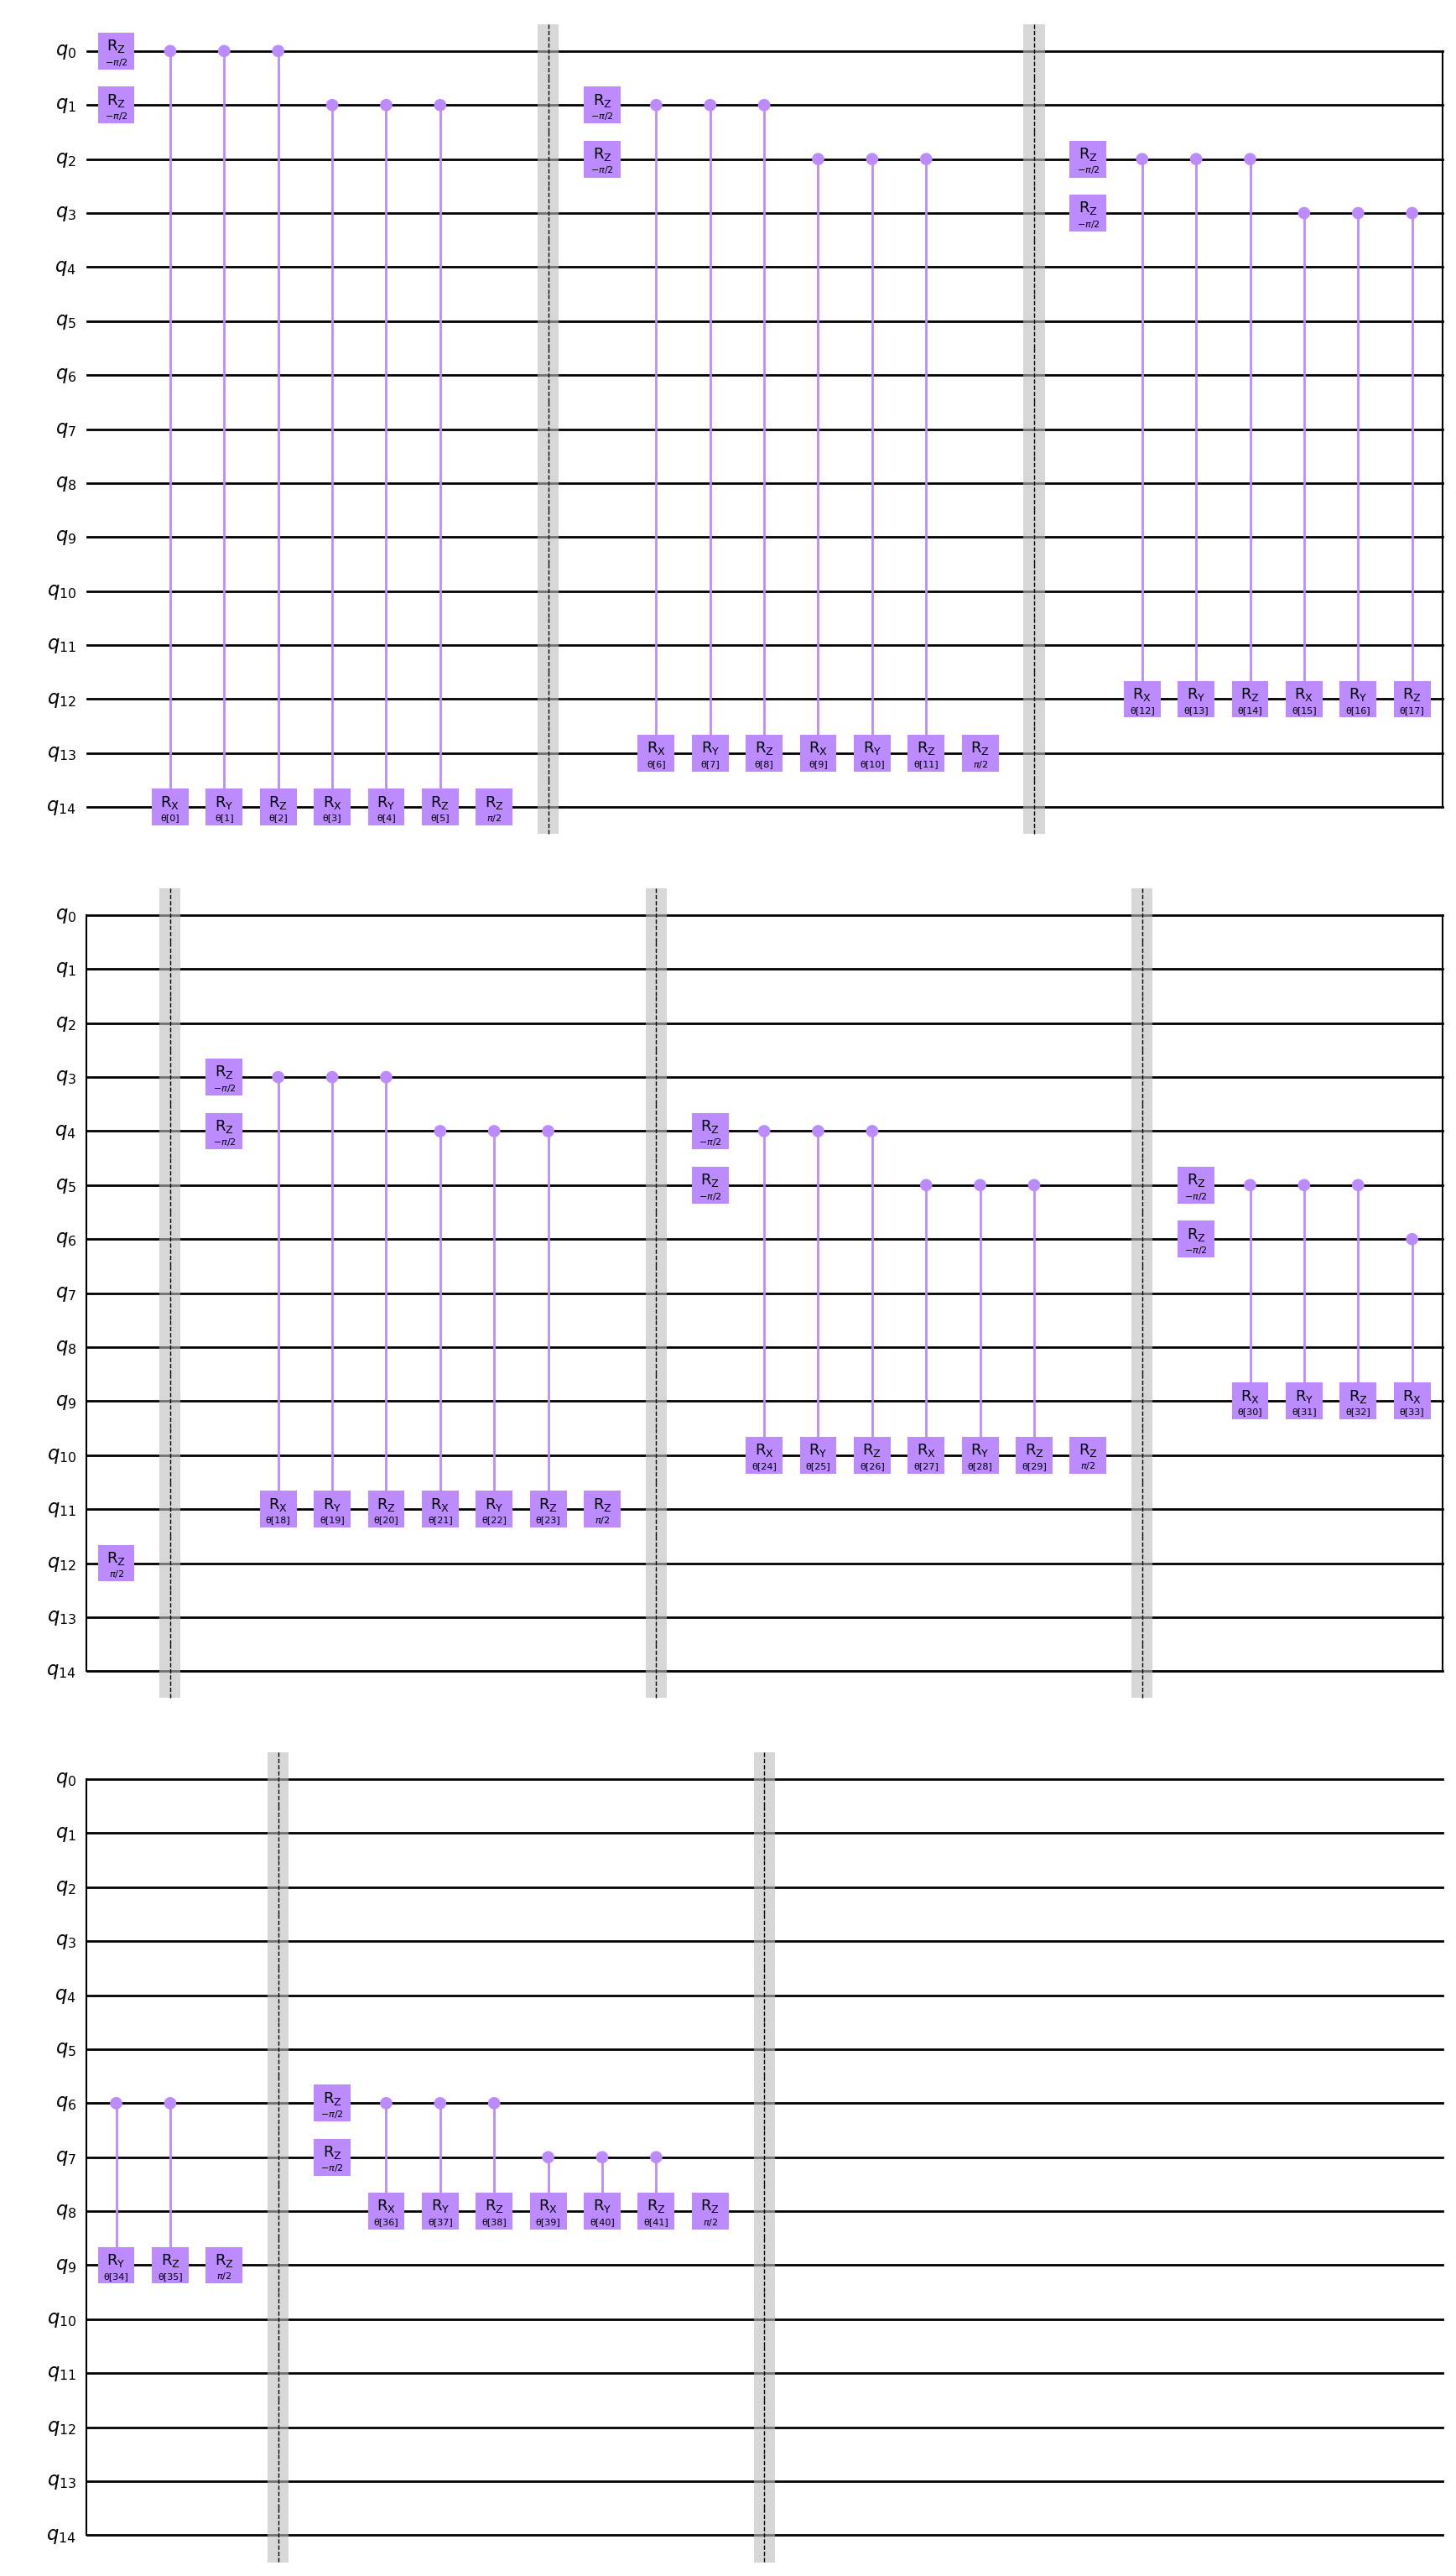

In [27]:
def CRCart_conv_circuit(kernel_size, params):
    target = QuantumCircuit(kernel_size+1)

    for i in range(kernel_size):
        target.rz(-np.pi / 2, i+1)
        target.crx(params[i*3], i+1, 0)
        target.cry(params[i*3+1], i+1, 0)
        target.crz(params[i*3+2], i+1, 0)
    target.rz(np.pi / 2, 0)
    return target  


def CRCart_conv_layer(kernel_size, info_qs, param_prefix):
    conv_size = info_qs - kernel_size + 1
    num_qubits = conv_size + info_qs

    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))

    param_index = 0
    params = ParameterVector(param_prefix, length=conv_size * kernel_size * 3)
    
    for i in range(conv_size):
        q_list = [qubits[-(i+1)]]
        q_list.extend(qubits[i:i+kernel_size])
        qc = qc.compose(other=CRCart_conv_circuit(kernel_size, params[param_index : (param_index + 3 * kernel_size)]), qubits=q_list)
        qc.barrier()
        param_index += 3 * kernel_size
    
    qc_inst = qc.to_instruction()
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

circuit = CRCart_conv_layer(2, 8, "θ")
circuit.decompose().draw("mpl")

Pooling Layers

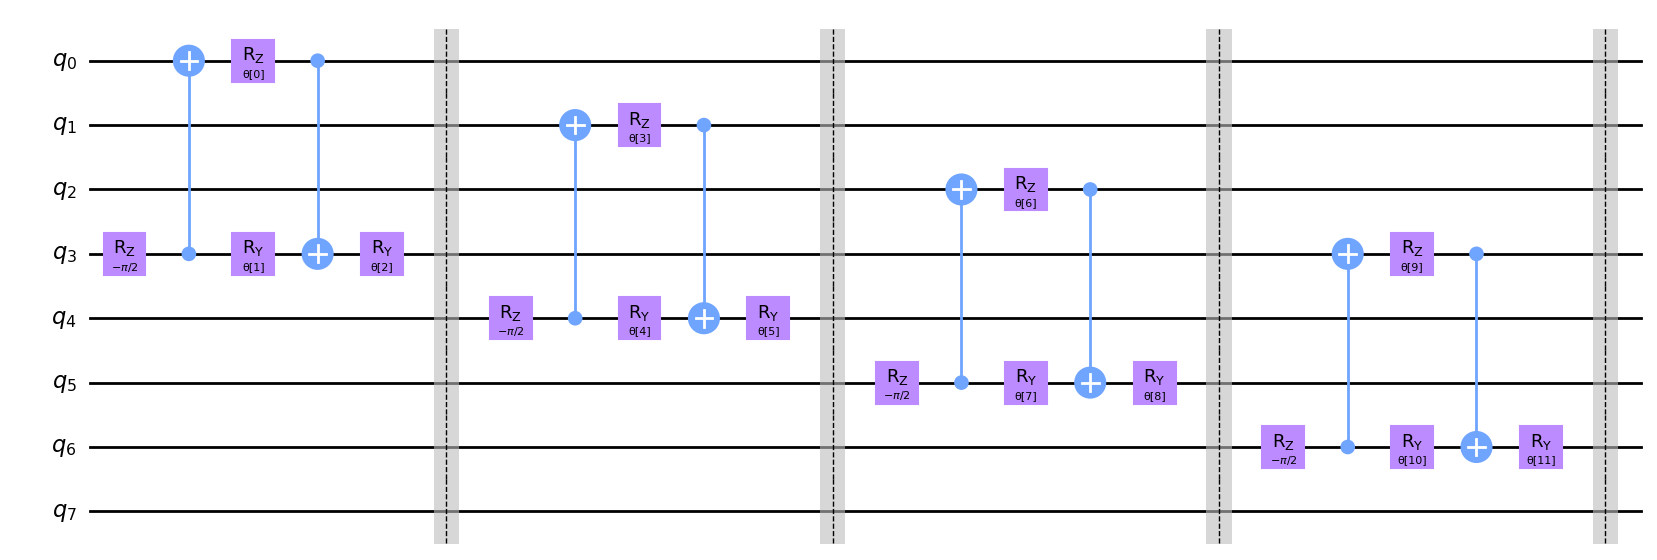

In [28]:

#Defining a single pooling layer
def pooling_circuit(params) :
    target = QuantumCircuit(2)          #We are defining a quantum circuit with 2 qubits
    target.rz(-np.pi / 2,1)             #Applying the Rz gate to the qubit at position 1
    target.cx(1,0)                      #Apply CNOT gate with second qubit as control and first qubit as control
    target.rz(params[0], 0)             #Apply a rotation angle stored in params[0] to qubit in position 0
    target.ry(params[1],1)
    target.cx(0,1)
    target.ry(params[2],1)

    return target

#Define the layer  for a larger number of qubits
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks) #The number of qubits is equal to the total number of sources and sinks. Sources are original qubits and sinks are qubits after pooling
    qc = QuantumCircuit(num_qubits, name = "Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length = num_qubits // 2*3) #We divide num_qubits by 2 as we need a parameter vector for each pair of source and sinks. 
    # The number of paramters is 3 as we use the 3 of them in the pooling_circuit code. The params array contain a rotation angle for X, Y and Z axis. Hence size is 3

    for source, sink in zip(sources, sinks):
        qc = qc.compose(pooling_circuit(params[param_index : (param_index + 3)]), [source, sink]) #The first three parameters are sent to compose the circuit on the source and sink
        qc.barrier()
        param_index+=3 #Switch to the next set of 3 parameters after first layer
    
    qc_inst = qc.to_instruction() #Convert the quantum circuit into a single instruction to add to other circuits
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc # Return the quantum circuit


sources = [0,1, 2,3]
sinks = [3, 4,5,6]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

## Generating Dataset

In [29]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6,8))
    ver_array = np.zeros((4,8))
    j = 0
    for i in range(0,7):
        if i !=3:
            hor_array[j][i] = np.pi/2
            hor_array[j][i+1] = np.pi/2
            j+=1
    j =0
    for i in range(0,4):
        ver_array[j][i] = np.pi/2
        ver_array[j][i+4] = np.pi/2
        j+=1
    
    for n in range(num_images):
        rng = algorithm_globals.random.integers(0,2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0,6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0,4)
            images.append(np.array(ver_array[random_image]))
        
        #noise generation
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi/4)
        
    return images,labels


In [30]:
images, labels = generate_dataset(150)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3
)

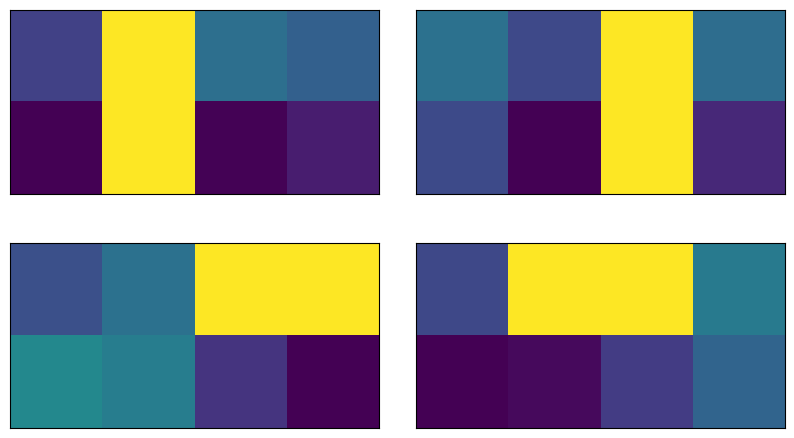

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2,4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

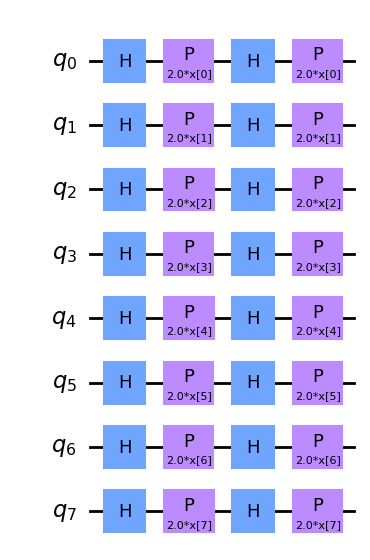

In [32]:
feature_map = ZFeatureMap(8)
feature_map.decompose().draw("mpl")

## Training

In [33]:

feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

     ┌───────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐
q_0: ┤ Rx(с1[0]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rx(π/2) ├
     ├───────────┤└────┬────┘└────┬────┘└────┬────┘└────┬────┘
q_1: ┤ Rx(с1[1]) ├─────■──────────■──────────┼──────────┼─────
     ├───────────┤┌─────────┐┌─────────┐     │          │     
q_2: ┤ Rx(с1[2]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├─────■──────────■─────
     └───────────┘└────┬────┘└────┬────┘                      
q_3: ──────────────────■──────────■───────────────────────────
                                                              
     ┌───────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐
q_0: ┤ Rx(с1[3]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rx(π/2) ├
     ├───────────┤└────┬────┘└────┬────┘└────┬────┘└────┬────┘
q_1: ┤ Rx(с1[4]) ├─────■──────────■──────────┼──────────┼─────
     ├───────────┤┌─────────┐┌─────────┐     │          │     
q_2: ┤ Rx(с1[5]) ├┤ Rz(π/2) ├┤ Rx(π/2) ├─────■──────────■─────
     └───────────┘└────┬────┘└────┬────┘               

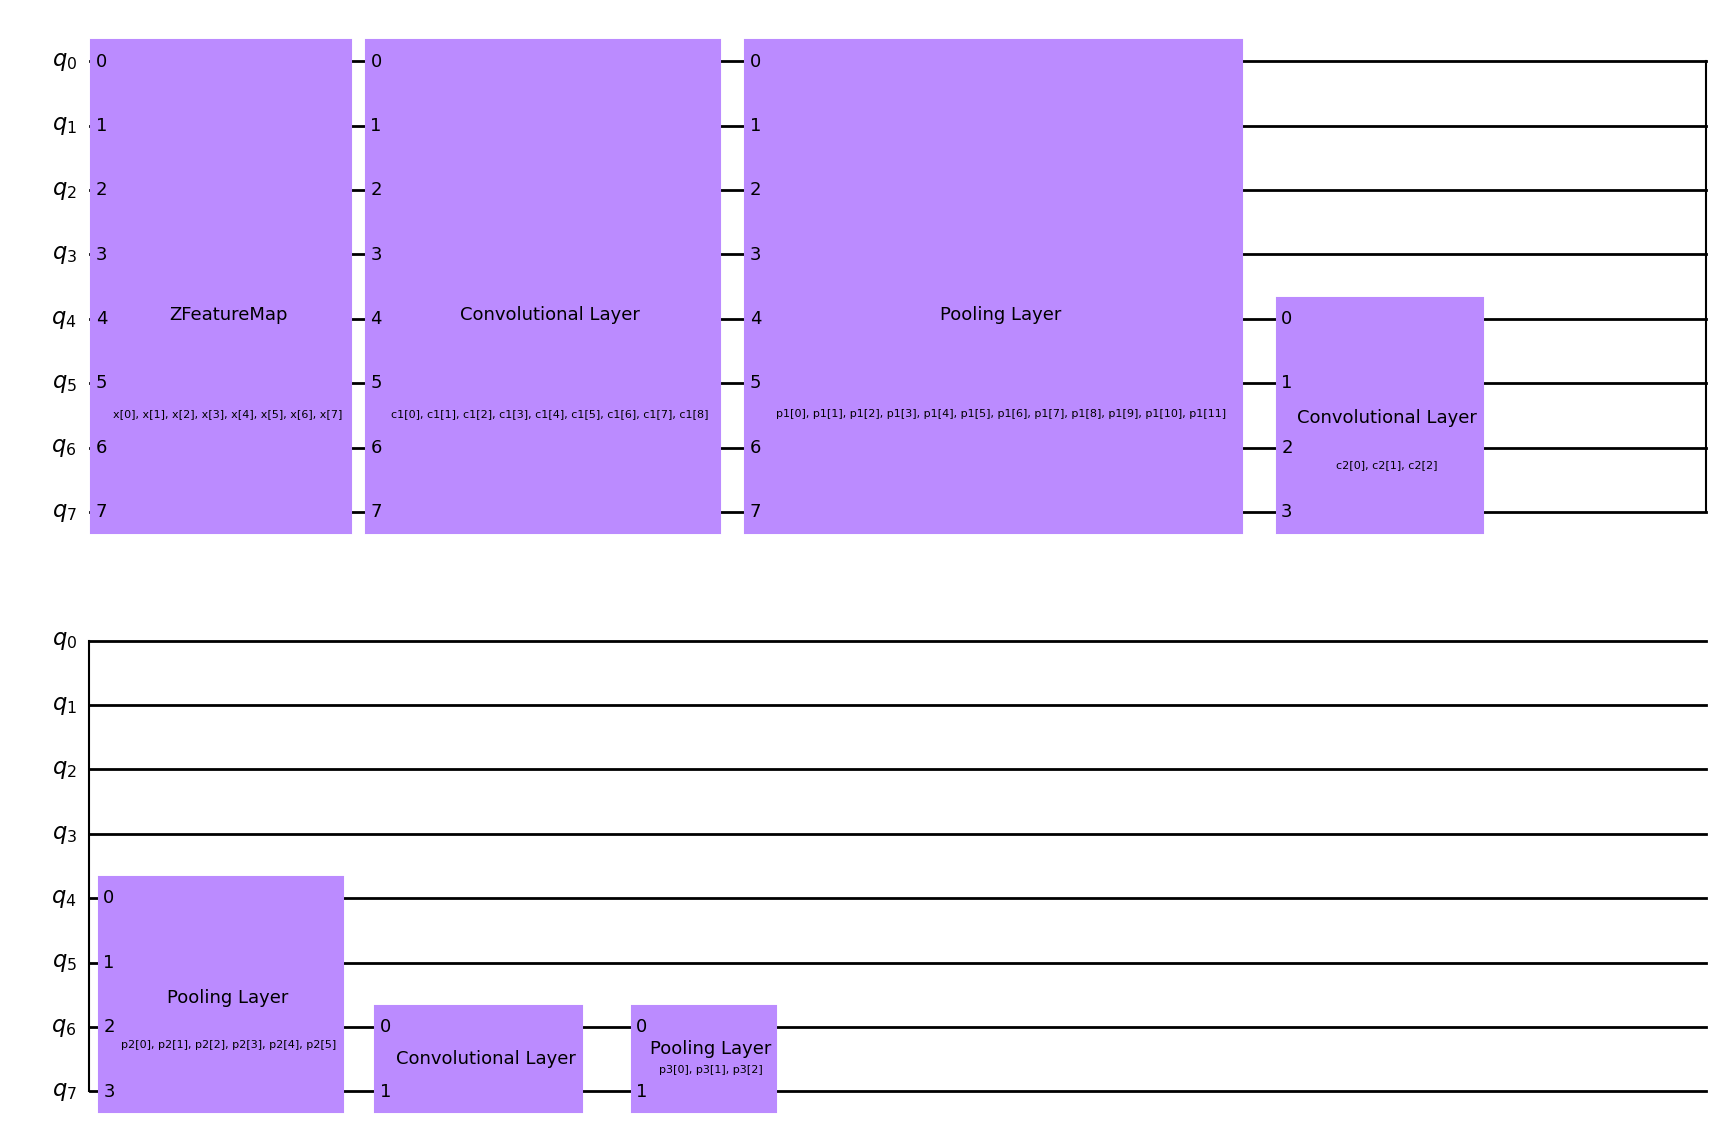

In [34]:
circuit.draw("mpl")

### CRCart CNN Definition

In [35]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(15, name="Ansatz")

# First Convolutional Layer
ansatz.compose(CRCart_conv_layer(5, 8, "с1"), list(range(12)), inplace=True)

# Second Convolutional Layer
ansatz.compose(CRCart_conv_layer(3, 4, "c2"), list(range(8,14)), inplace=True)

# Third Convolutional Layer
ansatz.compose(CRCart_conv_layer(2, 2, "c3"), list(range(12,15)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(15)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(15), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

CircuitError: 'Number of items in qubits parameter (5) does not match number of qubits in the circuit (6).'

In [ ]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
initial_point = np.random.rand(33) #24 = 8*3

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
    initial_point=initial_point,
)

## Testing the Model

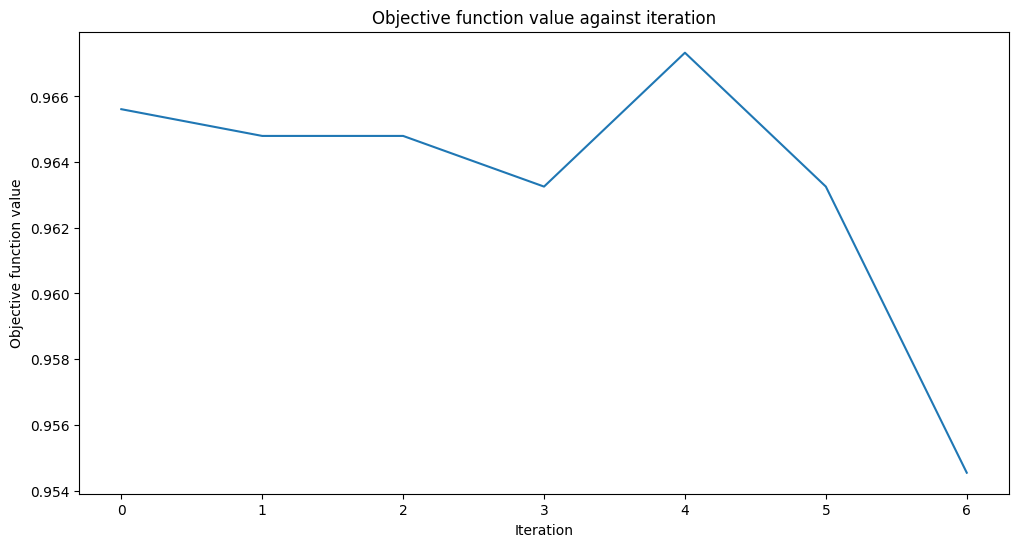

Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_cobyla_py.py", line 258, in calcfc
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
    f = fun(np.copy(x), *args)
  File "/opt/homebrew/lib/python3.10/site-packages/qiskit_machine_learning/algorithms/trainable_model.py", line 271, in objective
    objective_value = function.objective(objective_weights)
  File "/opt/homebrew/lib/python3.10/site-packages/qiskit_machine_learning/algorithms/objective_functions.py", line 115, in objective
    predict = self._neural_network_forward(weights)
  File "/opt/homebrew/lib/python3.10/site-packages/qiskit_machine_learning/algorithms/objective_functions.py", line 102, in _neural_network_forward
    self._last_forward = self._neural_network.forward(self._X, weights)
  File "/opt/homebr

: 

: 

In [ ]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 60.0%


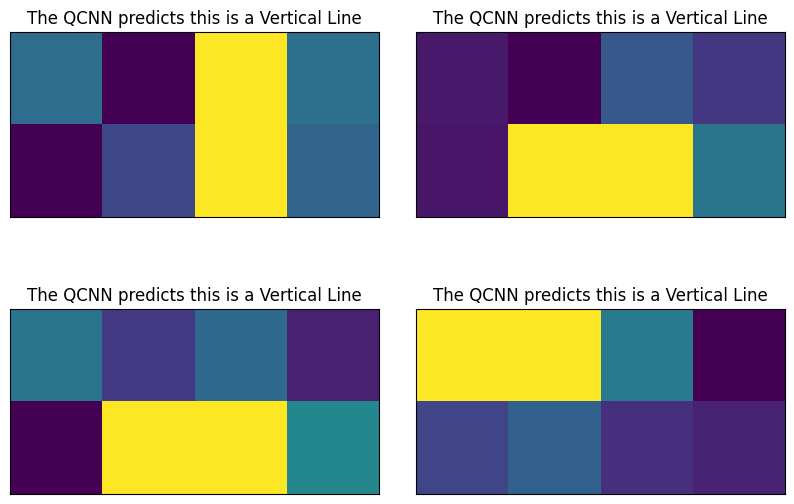

In [ ]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [ ]:
print(len(y))

105
